# importing data from kaggle using kagglehub

In [ ]:
import kagglehub
paultimothymooney_chest_xray_pneumonia_path = kagglehub.dataset_download('paultimothymooney/chest-xray-pneumonia')

print('Data source import complete.')

In [ ]:
import os
import numpy as np
import pandas as pd

In [ ]:
paultimothymooney_chest_xray_pneumonia_path

'/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2'

In [ ]:
os.listdir('/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/')

['val', 'chest_xray', '__MACOSX', 'train', 'test']

In [ ]:
train='/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/train'
test='/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/test'
valid='/root/.cache/kagglehub/datasets/paultimothymooney/chest-xray-pneumonia/versions/2/chest_xray/val'

In [ ]:
print(os.listdir(train)), print(os.listdir(test)), print(os.listdir(valid))

['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']
['NORMAL', 'PNEUMONIA']


(None, None, None)

# Loading images using image_dataset_from_directory module

In [ ]:
from keras.preprocessing import image_dataset_from_directory

train_data = image_dataset_from_directory(train,
                                          label_mode='binary',
                                          image_size=(224, 224),
                                          subset='training',
                                          seed=123,
                                          validation_split=0.2)

valid_data = image_dataset_from_directory(train,
                                          label_mode='binary',
                                          image_size=(224, 224),
                                          subset='validation',
                                          seed=123,
                                          validation_split=0.2)

test_data = image_dataset_from_directory(test,
                                         image_size=(224, 224),
                                         label_mode='binary')

Found 5216 files belonging to 2 classes.
Using 4173 files for training.
Found 5216 files belonging to 2 classes.
Using 1043 files for validation.
Found 624 files belonging to 2 classes.


In [ ]:
shape=(224, 224, 3)

# Visualization

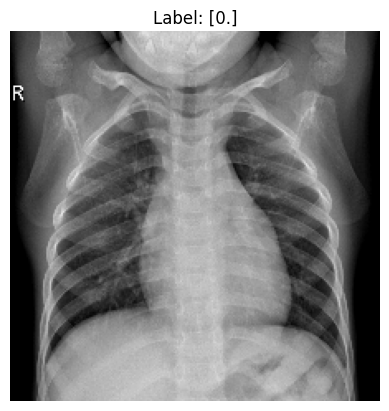

In [ ]:
import matplotlib.pyplot as plt

for images, labels in train_data.take(1):
    plt.imshow(images[0].numpy().astype("uint8")) # Using uint8 ensures that pixel values fall within 255 range
    plt.title(f"Label: {labels[0].numpy()}")
    plt.axis("off")
    plt.show()

In [ ]:
for images, labels in train_data.take(1):
  NUM_CLASSES = len(labels.shape)

# Data Augmentation

In [ ]:
from tensorflow.keras import layers
from tensorflow import keras

data_augmentation = keras.Sequential([
    layers.Input(shape),
    layers.RandomFlip('horizontal'),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.2),
    layers.RandomBrightness(0.2)
])

In [ ]:
import tensorflow as tf

def apply_augmentation(image, label):
    image = data_augmentation(image)
    return image, label

train_ds = train_data.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = valid_data.prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
# normalization
train_ds = train_ds.map(lambda x, y: (x / 255.0, y))
val_ds = val_ds.map(lambda x, y: (x / 255.0, y))
test_ds = test_ds.map(lambda x, y: (x / 255.0, y))

# Preparing the architecture to train images

In [ ]:
from keras.layers import Dense, Rescaling, Conv2D, Input, Flatten, BatchNormalization, MaxPooling2D, GlobalAveragePooling2D, Dropout
from keras.models import Model, Sequential
from keras.applications import VGG19

base_model = VGG19(
    include_top=False,
    weights="imagenet",
    input_shape=shape,
    classes=NUM_CLASSES,
    pooling='max'
)

base_model.trainable = True

model_vgg19 = Sequential()
model_vgg19.add(Input(shape))

model_vgg19.add(base_model)
model_vgg19.add(Dense(512, activation='relu'))
model_vgg19.add(Dense(1, activation='sigmoid'))
model_vgg19.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg19 (Functional)                   │ (None, 512)                 │      20,024,384 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │             513 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,287,553 (77.39 MB)

 Trainable params: 20,287,553 (77.39 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
from keras.optimizers import Adam

opt = Adam(learning_rate=0.0001)

model_vgg19.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [42]:
from keras.callbacks import EarlyStopping

early = EarlyStopping(patience=5, monitor='val_loss',  restore_best_weights=True )

# Training

In [43]:
model_vgg19.fit(train_ds,
          epochs=50,
          validation_data=val_ds,
          callbacks=[early])

Epoch 1/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 122s 842ms/step - accuracy: 0.7595 - loss: 0.5243 - val_accuracy: 0.9099 - val_loss: 0.2169
Epoch 2/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 114s 868ms/step - accuracy: 0.8513 - loss: 0.3130 - val_accuracy: 0.9214 - val_loss: 0.1827
Epoch 3/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 164s 1s/step - accuracy: 0.8880 - loss: 0.2440 - val_accuracy: 0.9108 - val_loss: 0.1867
Epoch 4/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - accuracy: 0.8980 - loss: 0.2475 - val_accuracy: 0.8945 - val_loss: 0.2534
Epoch 5/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 113s 799ms/step - accuracy: 0.9275 - loss: 0.1823 - val_accuracy: 0.9760 - val_loss: 0.0926
Epoch 6/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 149s 860ms/step - accuracy: 0.9345 - loss: 0.1678 - val_accuracy: 0.8734 - val_loss: 0.2942
Epoch 7/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 137s 821ms/step - accuracy: 0.9449 - loss: 0.1469 - val_accuracy: 0.9444 - val_loss: 0.1305
Epoch 8/50
131/131 ━━━━━━━━━━━━━━━━━━━━ 110s 836ms/step - accuracy: 0.9438 - loss:

In [44]:
model_vgg19.evaluate(val_ds)

33/33 ━━━━━━━━━━━━━━━━━━━━ 9s 279ms/step - accuracy: 0.9873 - loss: 0.0442


[0.06402277946472168, 0.9798657894134521]

In [51]:
model_vgg19.evaluate(test_ds)

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 192ms/step - accuracy: 0.8702 - loss: 0.4621


[0.5251871943473816, 0.8605769276618958]

In [47]:
model_vgg19.save('my_model.keras')

# visualizing trained images

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step


<ipython-input-55-5cdac717e825>:36: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  actual_class_label = class_names[int(actual_class)]


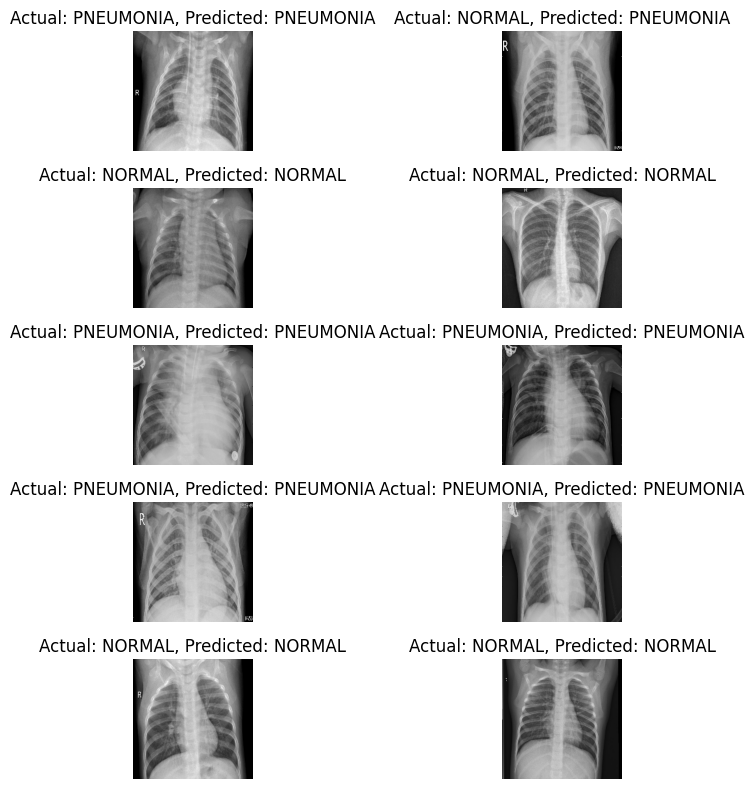

In [55]:
import tensorflow as tf
import matplotlib.pyplot as plt

images, labels = next(iter(test_ds)) # accessing first batch or images and labels(using for image_dataset_from_directory module)

predicted_data = model_vgg19.predict(images)

predicted_labels = (predicted_data > 0.5).astype("int32")

# Number of images to display
num_images = 10

# Randomly select indices to display
random_indices = np.random.choice(images.shape[0], num_images, replace=False)

# Create a plot for the images
plt.figure(figsize=(10, 8))

for i, idx in enumerate(random_indices):
    actual_class = labels[idx].numpy()
    predicted_class = predicted_labels[idx][0]


    img = images[idx].numpy()
    img = np.clip(img, 0, 1)

    # Display the image
    plt.subplot(5, 2, i + 1)
    plt.imshow(img)
    plt.axis('off')

    # class labels for actual and predicted classes
    class_names = train_data.class_names  # class names

    # Converting actual_class and predicted_class to scalar integers (index)
    actual_class_label = class_names[int(actual_class)]
    predicted_class_label = class_names[int(predicted_class)]

    # title
    plt.title(f"Actual: {actual_class_label}, Predicted: {predicted_class_label}")

# plotting
plt.tight_layout()
plt.show()
